In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [2]:
input_file = 'holmes.txt'

with open(input_file,'r', encoding = 'utf-8') as infile:
  data = infile.read()

In [3]:
data[:200]

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swift Series\n\nWe name these Etext files as they are numbered in the books,\n\ni.e. This is #4 in the seri"

In [4]:
data = data[:500000]

# Clean Text

In [5]:
def remove_emojis_and_special_characters(text):
  #removing special characters
  text=re.sub(r'[^a-zA-Z0-9\s]','',text)

  #removing extra spaces
  text = re.sub(' +',' ',text)

  return text

In [6]:
#Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
  #Spliting by newline
  sentences = data.split('\n')
  for i in range(len(sentences)):
    sentences[i]= remove_emojis_and_special_characters(sentences[i])
  #remove leading and trailing spaces
  sentences = [s.strip() for s in sentences]
  #Droping empty sentences
  sentences = [s for s in sentences if len(s)>0]

  tokenized = []
  for sentence in sentences:
    sentence = sentence.lower()
    tokenized.append(sentence)
  return tokenized

tokenized_sentences = preprocess_pipeline(data)

In [7]:
tokenized_sentences[:10]

['project gutenbergs etext of tom swift and his submarine boat',
 '4 in the victor appletons tom swift series',
 'we name these etext files as they are numbered in the books',
 'ie this is 4 in the series so the file name is 04tomxxxxxx',
 'where the xs are place holders for editon and file type such',
 'as 04tom10txt and 04tom10zip when we do a htm 04tom10hhtm',
 'copyright laws are changing all over the world be sure to check',
 'the copyright laws for your country before posting these files',
 'please take a look at the important information in this header',
 'we encourage you to keep this file on your own disk keeping an']

In [8]:
#Tokenizing words (Out of vocabulary tokenizer)
#Assigning unique ids
tokenizer = Tokenizer(oov_token = '<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) +1

"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

#Generating input sequences
input_sequences = []
for line in tokenized_sentences:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

#Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,maxlen= max_sequence_len,padding='pre'))

In [9]:
input_sequences

array([[   0,    0,    0, ...,    0,  218, 1569],
       [   0,    0,    0, ...,  218, 1569,  211],
       [   0,    0,    0, ..., 1569,  211,    5],
       ...,
       [   0,    0,    0, ...,   12,   37,    4],
       [   0,    0,    0, ...,   37,    4,   15],
       [   0,    0,    0, ...,    4,   15, 6119]], dtype=int32)

In [10]:
#Removing last word for train test spliting
X,labels= input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels,num_classes=total_words) #conversion to binary no

In [11]:
#Spliting data to training, validation and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Training LSTM Model

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=30, validation_data=(X_val, y_val), verbose=1)

Epoch 1/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.0955 - loss: 6.2834 - val_accuracy: 0.1389 - val_loss: 5.6470
Epoch 2/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.1544 - loss: 5.1520 - val_accuracy: 0.1519 - val_loss: 5.6231
Epoch 3/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1770 - loss: 4.6583 - val_accuracy: 0.1534 - val_loss: 5.7466
Epoch 4/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2000 - loss: 4.2711 - val_accuracy: 0.1520 - val_loss: 5.9800
Epoch 5/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2207 - loss: 3.9942 - val_accuracy: 0.1571 - val_loss: 6.1952
Epoch 6/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.2345 - loss: 3.8021 - val_accuracy: 0.1541 - val_loss: 6.4530
Epoch 7/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2484 - loss: 3.6638 - val_accuracy: 0.1474 - val_loss: 6.6669
Epoch 8/30
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2575 - loss: 3

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

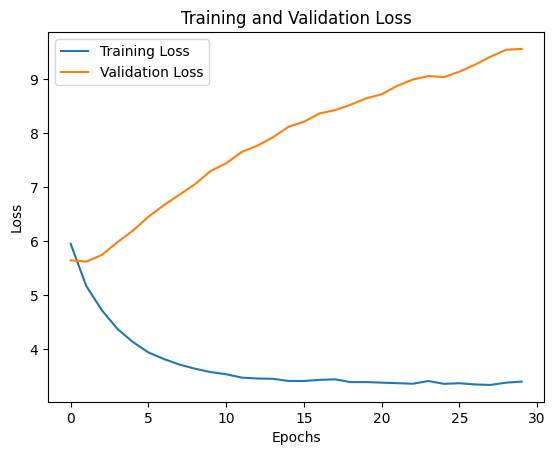

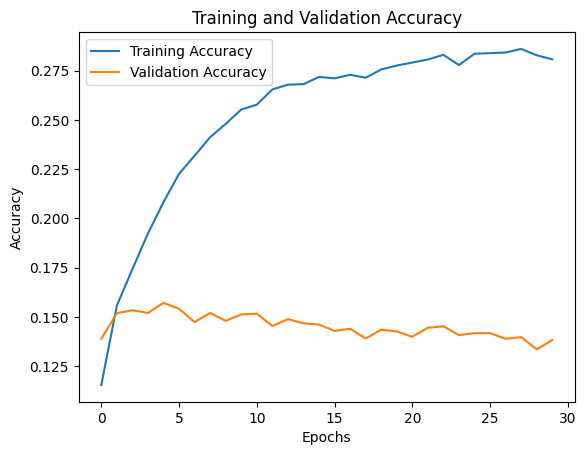

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Displaying Results

In [15]:
from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text,model,tokenizer):
  top_five_words = predict_top_five_words(model,tokenizer,seed_text)
  heading_app = f"<h1>Sentence Auto Completion App</h1>"
  output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
  javascript_code = f"""
  <script>
    var newWindow = window.open("","_blank");
    newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
  </script>
  """
  return HTML(javascript_code)


In [20]:
seed_text = "How are"
predict_and_display_top_five_words(seed_text,model, tokenizer,)

In [21]:
seed_text = "I love"
predict_top_five_words(model, tokenizer, seed_text)

['young', 'signal', 'surface', 'runabout', 'assented']

In [22]:
seed_text = "How are"
predict_top_five_words(model, tokenizer, seed_text)

['you', 'not', 'he', 'we', 'it']

In [23]:
# Save model and tokenizer
model.save('sentence_completion_model.h5')

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
